Import a bunch of libraries and load the dataset

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import PowerTransformer
from sklearn.model_selection import train_test_split
from sklearn.svm import SVR
from sklearn.metrics import r2_score,mean_absolute_error,  mean_squared_error, accuracy_score
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer

In [3]:
df = pd.read_csv('bodyfat.csv')

# EDA - Exploratory Data Analisys

First of all let's remove the "Density" column because directly related to "BodyFat" (our target) by the Siri equation:

*% Body Fat = (495 / Body Density) - 450*

If not, we're going to have a target leakage

In [4]:
df.drop(columns='Density', inplace=True)

Then convert Weight and Height from lbs/in to Kg and meters (mandatory if we want to calculate BMI and in order to uniform with unit measures of the other features)

In [5]:
df['Weight'] = df['Weight']/2.2046
df['Height'] = df['Height']*0.0254

And now let's take a look at the number of entries, data types and missing values

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 252 entries, 0 to 251
Data columns (total 14 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   BodyFat  252 non-null    float64
 1   Age      252 non-null    int64  
 2   Weight   252 non-null    float64
 3   Height   252 non-null    float64
 4   Neck     252 non-null    float64
 5   Chest    252 non-null    float64
 6   Abdomen  252 non-null    float64
 7   Hip      252 non-null    float64
 8   Thigh    252 non-null    float64
 9   Knee     252 non-null    float64
 10  Ankle    252 non-null    float64
 11  Biceps   252 non-null    float64
 12  Forearm  252 non-null    float64
 13  Wrist    252 non-null    float64
dtypes: float64(13), int64(1)
memory usage: 27.7 KB


Good, no null/missing values and no strings to encode. Just numbers, that's what we want.
Now let's give a look at outliers and distribution

In [7]:
df.describe()

,BodyFat,Age,Weight,Height,Neck,Chest,Abdomen,Hip,Thigh,Knee,Ankle,Biceps,Forearm,Wrist
count,252.000000,252.000000,252.000000,252.000000,252.000000,252.000000,252.000000,252.000000,252.000000,252.000000,252.000000,252.000000,252.000000,252.000000
mean,19.150794,44.884921,81.159578,1.781780,37.992063,100.824206,92.555952,99.904762,59.405952,38.590476,23.102381,32.273413,28.663889,18.229762
std,8.368740,12.602040,13.330835,0.093037,2.430913,8.430476,10.783077,7.164058,5.249952,2.411805,1.694893,3.021274,2.020691,0.933585
min,0.000000,22.000000,53.751247,0.749300,31.100000,79.300000,69.400000,85.000000,47.200000,33.000000,19.100000,24.800000,21.000000,15.800000
25%,12.475000,35.750000,72.121927,1.733550,36.400000,94.350000,84.575000,95.500000,56.000000,36.975000,22.000000,30.200000,27.300000,17.600000
50%,19.200000,43.000000,80.059875,1.778000,38.000000,99.650000,90.950000,99.300000,59.000000,38.500000,22.800000,32.050000,28.700000,18.300000
75%,25.300000,54.000000,89.358614,1.835150,39.425000,105.375000,99.325000,103.525000,62.350000,39.925000,24.000000,34.325000,30.000000,18.800000
max,47.500000,81.000000,164.723759,1.974850,51.200000,136.200000,148.100000,147.700000,87.300000,49.100000,33.900000,45.000000,34.900000,21.400000


In [8]:
print("Kurtosis:")
print(df.kurt().sort_values(ascending=False))
print()
print("Skewness")
print(df.skew().sort_values())

Kurtosis:
Height     59.544302
Ankle      11.945194
Hip         7.471352
Weight      5.269514
Neck        2.719615
Thigh       2.665714
Abdomen     2.248824
Knee        1.061536
Chest       0.987282
Forearm     0.866309
Biceps      0.498498
Wrist       0.395678
BodyFat    -0.333811
Age        -0.416441
dtype: float64

Skewness
Height    -5.384987
Forearm   -0.219333
BodyFat    0.146353
Wrist      0.281614
Age        0.283521
Biceps     0.285530
Knee       0.516744
Neck       0.552620
Chest      0.681556
Thigh      0.821210
Abdomen    0.838418
Weight     1.205263
Hip        1.497127
Ankle      2.255134
dtype: float64


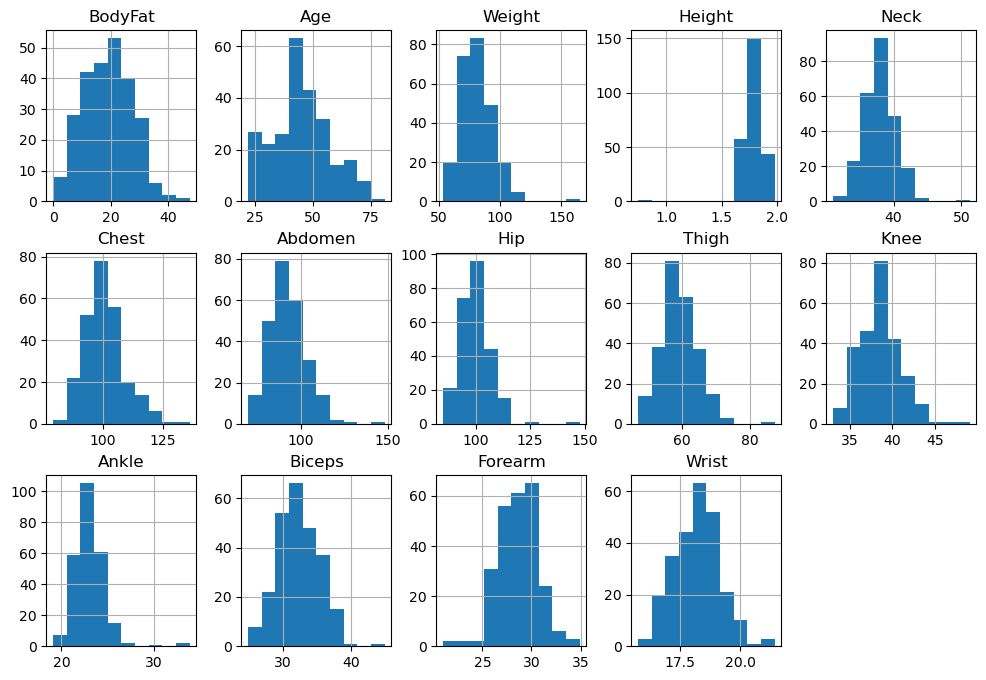

In [9]:
df.hist(figsize=(12, 8), layout=(3, 5));

Mmmm...there are few outliers here (Weight, Height, Hip, Ankle...) so let's try to fix them.
I'm going to remove values out of scale choosing a tollerance of 2*IQR (Interquartile Range):

    keep if: Q1 - 2*IQR < value < Q3 + 2*IQR
    remove otherwise

In [10]:
before_rows = df.shape[0]

def remove_outliers_iqr(data, column_name):
    Q1 = data[column_name].quantile(0.25)
    Q3 = data[column_name].quantile(0.75)
    IQR = Q3 - Q1

    lower_bound = Q1 - 2 * IQR
    upper_bound = Q3 + 2 * IQR

    return data[(data[column_name] >= lower_bound) & (data[column_name] <= upper_bound)]


for column in df.columns:
    df = remove_outliers_iqr(df, column)


filtered_rows = df.shape[0]
print("Before: ", before_rows, " - After: ", filtered_rows)

Before:  252  - After:  244


8 rows removed, acceptable. I didn't try to replace outliers with in-range values because changing some of them could lead to a  completely different body fat value in real life.

Check the new situation:

In [11]:
print("Kurtosis:")
print(df.kurt().sort_values(ascending=False))
print()
print("Skewness")
print(df.skew().sort_values())

Kurtosis:
Forearm    0.406070
Chest     -0.011472
Hip       -0.039747
Ankle     -0.061384
Thigh     -0.066268
Knee      -0.123478
Wrist     -0.198154
Neck      -0.206578
Abdomen   -0.207445
BodyFat   -0.215750
Weight    -0.308536
Height    -0.399496
Age       -0.404808
Biceps    -0.413227
dtype: float64

Skewness
Neck      -0.059424
Forearm   -0.058815
Wrist      0.042819
Biceps     0.073224
Height     0.110862
BodyFat    0.157722
Knee       0.192897
Thigh      0.193155
Ankle      0.257274
Age        0.269222
Hip        0.271895
Weight     0.299614
Abdomen    0.303424
Chest      0.403247
dtype: float64


Much better. Let's see correlation between features

<Axes: >

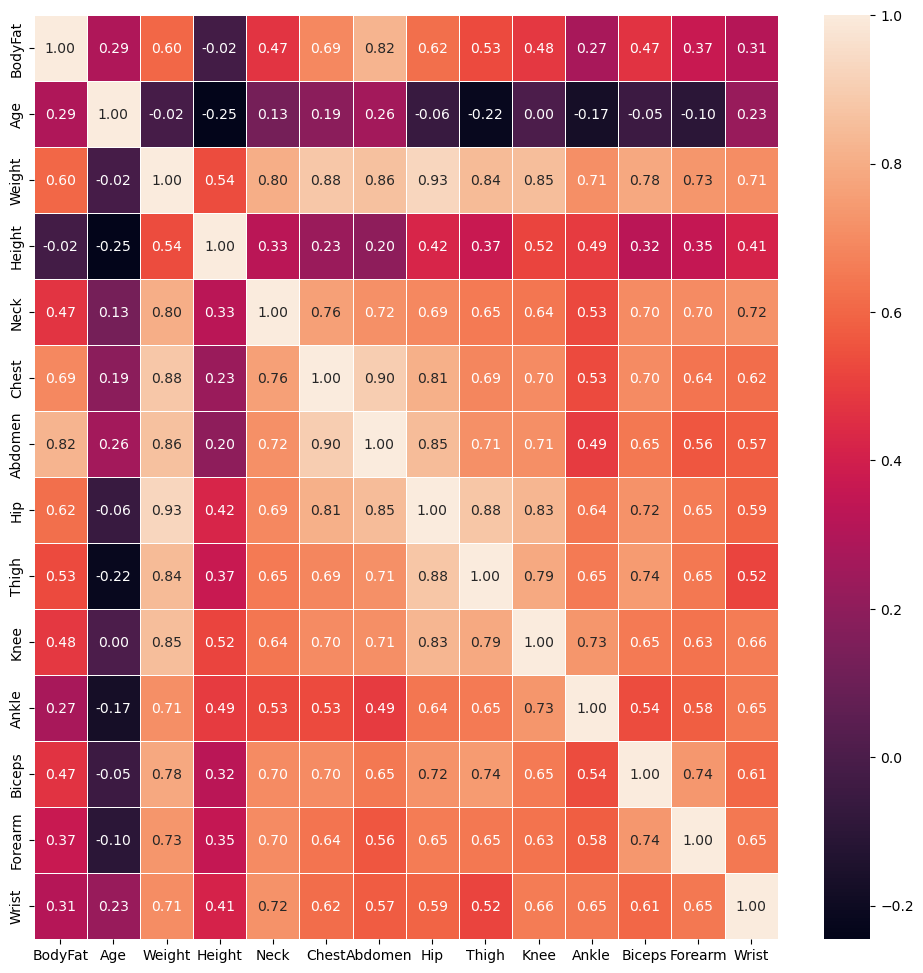

In [12]:
plt.figure(figsize=(12,12))
sns.heatmap(df.corr(),annot=True,linewidth=0.5,fmt="0.2f")

There are some features highly related to each others (Hip-Weight, Abdomen-Chest, Hip-Thigh...). Before choosing which one drop and/or combine, let's see at what science says about the correlation between body fat and our features. Here is GPT4 response:

---
The relationship between various anthropometric measurements and age with body fat percentage is an area of significant interest in health and fitness research. Here's how these factors correlate with body fat percentage, sorted by relevance:

1. **Abdomen Circumference**: This is one of the strongest indicators of body fat percentage due to its association with visceral fat. Visceral fat accumulation around the internal organs is a significant health risk factor.

2. **Hip Circumference**: Used to calculate the waist-to-hip ratio, it is indicative of fat distribution and correlates with body fat levels. A higher waist-to-hip ratio is associated with central obesity, a known risk factor for metabolic and cardiovascular diseases.

3. **Weight**: Total body weight includes fat, muscle, bones, and water. A higher body weight often correlates with a higher body fat percentage, especially in the absence of significant muscle mass.

4. **Age**: As people age, they tend to experience a shift in body composition, leading to increased body fat and decreased muscle mass, partially due to a slower metabolism and hormonal changes.

5. **Thigh Circumference**: Thigh circumference can reflect body fat but is also influenced by muscle mass in the legs. It's not as direct a measure as abdominal or hip circumference.

6. **Chest Circumference**: Changes in chest circumference can indicate variations in body fat, but this measure also includes muscle mass, making it a less direct indicator.

7. **Neck Circumference**: A larger neck circumference can signal greater fat deposits, which are associated with obesity-related health risks like sleep apnea.

8. **Biceps Circumference**: Reflects both fat and muscle mass. While changes in biceps circumference can indicate changes in body fat, this measure is also influenced by the muscle mass in the upper arm.

9. **Height**: Height is used in BMI calculations, which can be an indirect indicator of body fat but does not measure body fat directly.

10. **Forearm Circumference**: Typically not used to assess body fat, as the area is influenced more by muscle and bone density.

11. **Wrist Circumference**: Sometimes factored into body frame size assessments. It is not a direct measure of body fat but can have an indirect relationship.

12. **Ankle Circumference**: Not commonly associated with body fat measurement, it can reflect overall body size and issues like fluid retention.

13. **Knee Circumference**: This is generally not associated with body fat and is more relevant to assessments of bone and joint size.

While abdomen and hip circumferences are primary indicators of body fat percentage, each of these factors can provide insight into an individual's overall health and body composition, especially when several different measurements are considered together. Advanced methods like DEXA scans offer more precise measurements of body fat percentage but require specific equipment, whereas these anthropometric measures are more accessible and can still offer valuable health information.

---

This is an interesting analisys from which I get some points:

    1. the last 4 features (knee, ankle, wrist and forearm) do not seem to contribute too much to the body fat measure, so maybe we can drop them without loosing any relevant information
    2. Height can be more interesting if transformed into BMI
    3. Abdomen and Hips are the most valuable features (I guess abdomen is more related to males and hips to females but unfortunately we don't have a gender column)
    
So, proceed dropping and manipulating data

In [13]:
df['BMI']=df['Weight']/(df['Height']*df['Height'])
df.drop(columns=['Knee','Ankle','Wrist','Forearm'], inplace=True)

#final dataset
df.head()

,BodyFat,Age,Weight,Height,Neck,Chest,Abdomen,Hip,Thigh,Biceps,BMI
0,12.3,23,69.967341,1.72085,36.2,93.1,85.2,94.5,59.0,32.0,23.627041
1,6.1,22,78.585684,1.83515,38.5,93.6,83.0,98.7,58.7,30.5,23.334597
2,25.3,22,69.853942,1.68275,34.0,95.8,87.9,99.2,59.6,28.8,24.669010
3,10.4,26,83.802050,1.83515,37.4,101.8,86.4,101.2,60.1,32.4,24.883502
4,28.7,24,83.575252,1.80975,34.4,97.3,100.0,101.9,63.2,32.2,25.517641


# Prepare Dataset

Drop columns, split dataset and apply Power Transformer

In [14]:
X = df.drop(columns=['BodyFat'])
y = df['BodyFat']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=1)

pt = PowerTransformer()
X_train = pt.fit_transform(X_train)
X_test = pt.transform(X_test)

# Train Model


we are using a Support vector regressor(SVR) part of a support vector machine (SVM)

In [15]:
param_grid = {
    'C': [100, 120, 150],
    'gamma': ['auto',0.01, 0.005, 0.001],
    'epsilon': [3, 2, 1, 0.1],
    'tol': [1e-1, 1e-2, 1e-3]
}

svr = SVR(kernel='rbf')

grid_search = GridSearchCV(svr, param_grid, cv=6, scoring=make_scorer(r2_score))
grid_search.fit(X_train, y_train)

best_params = grid_search.best_params_

#train SVR withbest params and check results
best_svr = SVR(**best_params)
best_svr.fit(X_train, y_train)
y_pred_best_svr = best_svr.predict(X_test)

r2_best_svr = r2_score(y_test, y_pred_best_svr)
rmse_best_svr = mean_squared_error(y_test, y_pred_best_svr, squared=False)
accuracy_svr = accuracy_score(y_test, y_pred_best_svr)

print("Best params:", best_params)
print("Best SVR R2:", "{:.3f}".format(r2_best_svr))
print("Best SVR RMSE:", "{:.3f}".format(rmse_best_svr))
print("Best SVR RMSE:", "{:.3f}".format(accuracy_svr))

ValueError: continuous is not supported

In [ ]:
residual = y_test - y_pred_best_svr

plt.scatter(y_pred_best_svr, residual)
plt.title('Variance of predictions')
plt.xlabel('Prediction')
plt.ylabel('Residual')
plt.axhline(y=0, color='r', linestyle='--')
plt.show()